In [1]:
from utils import *
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision.datasets import CIFAR10
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

use_gpu = torch.cuda.is_available()

In [2]:
# torchvision.transforms.Normalize(mean, std)
# Given mean: (M1,...,Mn) and std: (S1,..,Sn) for n channels
data_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    
])

In [3]:
Trainset = CIFAR10(root = "./", train=True, transform=data_transform,download=False)
trainloader = torch.utils.data.DataLoader(Trainset, batch_size=4, 
                                          shuffle=True, num_workers=2)

In [4]:
Testset = CIFAR10(root = "./", train=False, transform=data_transform,download=False)
testloader = torch.utils.data.DataLoader(Testset, batch_size=4, 
                                          shuffle=True, num_workers=2)

In [5]:
dataloader = {"train": trainloader, "test": testloader}
dataset_sizes = get_size(Trainset, Testset)

In [6]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

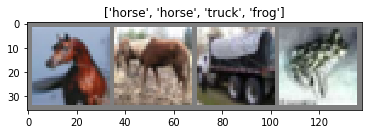

In [7]:
def imshow(img, titles = None):
    img = img.numpy().transpose((1, 2, 0))
    img = img / 2 + 0.5 # unnormalize
    plt.imshow(img)
    if titles is not None:
        plt.title(titles)
    
    
images, labels = next(iter(trainloader))
imshow(torchvision.utils.make_grid(images), titles = [classes[x] for x in labels])                    

In [8]:
class model_cifar(nn.Module):
    def __init__(self):
        super().__init__()
        # class torch.nn.Conv2d(in_channels, out_channels, kernel_size, 
        #     stride=1, padding=0, dilation=1, groups=1, bias=True)        
        
        self.conv1 = nn.Conv2d(3, 6, 5).cuda()
        self.pool  = nn.MaxPool2d(2,2).cuda()
        self.conv2 = nn.Conv2d(6, 16, 5).cuda()
        self.fc1   = nn.Linear(16*5*5, 120).cuda()
        self.fc2   = nn.Linear(120, 84).cuda()
        self.fc3   = nn.Linear(84, 10).cuda()
        self.relu  = nn.ReLU() # 实例化
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        
        x = x.view(-1, 16*5*5)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model_cifar10 = model_cifar().cuda()

In [9]:
class model_cifar10_fast(nn.Module):
    def __init__(self):
        super().__init__()
        # class torch.nn.Conv2d(in_channels, out_channels, kernel_size, 
        #     stride=1, padding=0, dilation=1, groups=1, bias=True)        
        # class torch.nn.MaxPool2d(kernel_size, stride=None, 
        #     padding=0, dilation=1, return_indices=False, ceil_mode=False)[s
        
        self.relu  = nn.ReLU().cuda() # 实例化
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2).cuda()
        self.Maxpool  = nn.MaxPool2d(kernel_size=3, stride=2).cuda()
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5, padding=2).cuda()
        self.Avgpool = nn.AvgPool2d(kernel_size=3, stride=2).cuda()
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding=2).cuda()
        
        self.fc  = nn.Linear(64*3*3, 10).cuda()
        # 此处不是3*3，会导致batchsize mismatch ,数据还需多多考虑
        
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.Maxpool(x)
        
        x = self.relu(self.conv2(x))
        x = self.Avgpool(x)
        
        x = self.relu(self.conv3(x))
        x = self.Avgpool(x)
        
        x = x.view(-1, 64*3*3)
        x = self.fc(x)
        return x

model_cifar10_f = model_cifar10_fast().cuda()

In [10]:
"""
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model_cifar10.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model_ft = train_model(model_cifar10, dataloader, criterion, optimizer, exp_lr_scheduler,
                       dataset_sizes, num_epochs=25)
"""

'\ncriterion = nn.CrossEntropyLoss()\n\noptimizer = optim.SGD(model_cifar10.parameters(), lr=0.001, momentum=0.9)\n\nexp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)\n\nmodel_ft = train_model(model_cifar10, dataloader, criterion, optimizer, exp_lr_scheduler,\n                       dataset_sizes, num_epochs=25)\n'

In [11]:
criterion = nn.CrossEntropyLoss()

optimizer_Adam = optim.Adam(model_cifar10_f.parameters())
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_Adam, step_size=7, gamma=0.1)

model_fast = train_model(model_cifar10_f, dataloader, criterion, optimizer_Adam, exp_lr_scheduler,
                       dataset_sizes, num_epochs=15)

Epoch 0/14
----------
train Loss: 1.4668 Acc: 0.4698
test Loss: 1.3289 Acc: 0.5337

Epoch 1/14
----------
train Loss: 1.1464 Acc: 0.6005
test Loss: 1.0500 Acc: 0.6310

Epoch 2/14
----------
train Loss: 1.0238 Acc: 0.6467
test Loss: 1.0033 Acc: 0.6545

Epoch 3/14
----------
train Loss: 0.9470 Acc: 0.6717
test Loss: 1.0198 Acc: 0.6565

Epoch 4/14
----------
train Loss: 0.9034 Acc: 0.6886
test Loss: 0.9245 Acc: 0.6873

Epoch 5/14
----------
train Loss: 0.8655 Acc: 0.7010
test Loss: 0.9319 Acc: 0.6833

Epoch 6/14
----------
train Loss: 0.8413 Acc: 0.7118
test Loss: 0.8930 Acc: 0.6968

Epoch 7/14
----------
train Loss: 0.6845 Acc: 0.7624
test Loss: 0.7677 Acc: 0.7430

Epoch 8/14
----------
train Loss: 0.6540 Acc: 0.7736
test Loss: 0.7626 Acc: 0.7430

Epoch 9/14
----------
train Loss: 0.6360 Acc: 0.7777
test Loss: 0.7524 Acc: 0.7514

Epoch 10/14
----------
train Loss: 0.6228 Acc: 0.7840
test Loss: 0.7431 Acc: 0.7513

Epoch 11/14
----------
train Loss: 0.6116 Acc: 0.7862
test Loss: 0.7333 Acc

In [14]:
print("For test")
classes_acc(model_cifar10_f, testloader, classes)

For test
Accuracy of plane : 80 %
Accuracy of   car : 87 %
Accuracy of  bird : 65 %
Accuracy of   cat : 58 %
Accuracy of  deer : 74 %
Accuracy of   dog : 65 %
Accuracy of  frog : 81 %
Accuracy of horse : 78 %
Accuracy of  ship : 86 %
Accuracy of truck : 84 %


In [15]:
print("For train")
classes_acc(model_cifar10_f, trainloader, classes)

For train
Accuracy of plane : 83 %
Accuracy of   car : 90 %
Accuracy of  bird : 71 %
Accuracy of   cat : 64 %
Accuracy of  deer : 79 %
Accuracy of   dog : 67 %
Accuracy of  frog : 84 %
Accuracy of horse : 83 %
Accuracy of  ship : 90 %
Accuracy of truck : 87 %
